In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import math
import matplotlib.pyplot as plt

In [2]:
class CenterNet_ResNet_backbone(nn.Module):
    def __init__(self, downsample = 4):
        super(CenterNet_ResNet_backbone, self).__init__()
        # pre-process
        self.preprocess = None
        # resnet backbone, down sample
        self.resnetBackbone = self._make_backbone()
        # up sample
        num_layer = 5 - int(math.log2(downsample))
        self.upsample = self._make_deconv_layer(num_layer)
        
        
    def forward(self, x):
        x_pre = x
        if self.preprocess is not None:
            x_pre = self.preprocess(x)
        
        x = self.resnetBackbone(x_pre)
        x = self.upsample(x)
        return x, x_pre
    
    def _make_deconv_layer(self, num_layer):
        inplanes = 2048
        outplanes = 1024
        layers = []
        for i in range(num_layer):
            fc = [
                        nn.Conv2d(inplanes, outplanes, 3, 1, 1),
                        nn.BatchNorm2d(outplanes),
                        nn.ReLU(inplace = True)
            ]
            up = [
                        nn.ConvTranspose2d(outplanes, outplanes, 4, 2, 1),
                        nn.BatchNorm2d(outplanes),
                        nn.ReLU(inplace = True)
            ]
            layers.extend(fc)
            layers.extend(up)
            inplanes = outplanes
            outplanes = int(outplanes/2)
        return nn.Sequential(*layers)
    
    def _make_backbone(self):
        resnet = torchvision.models.resnet50(pretrained=True)
        backboneList = [
                        resnet.conv1, resnet.bn1, 
                        resnet.relu, resnet.maxpool,
                        resnet.layer1, resnet.layer2,
                        resnet.layer3, resnet.layer4
                        ]
        return nn.Sequential(*backboneList)

In [3]:
centerResNetBackbone = CenterNet_ResNet_backbone()

In [552]:
x= torch.randn(5, 3, 512, 512)
centerResNetBackbone(x)[0].shape

torch.Size([5, 256, 128, 128])

In [744]:
class CenterNet_Network(nn.Module):
    def __init__(self, num_classes = 1, downsample = 4):
        super(CenterNet_Network, self).__init__()
        self.downsample = downsample
        self.centerNet_ResNet_backbone = CenterNet_ResNet_backbone(downsample)
        outplanes = 2**(10 - int(math.log2(downsample)))
        self.heatmap_network = nn.Sequential(
            nn.Conv2d(outplanes, outplanes, 3, 1, 1),
            nn.BatchNorm2d(outplanes),
            nn.ReLU(inplace=True),
            nn.Conv2d(outplanes, num_classes, 1),
            nn.BatchNorm2d(num_classes),
            nn.Sigmoid()
        )
        self.size_network = nn.Sequential(
            nn.Conv2d(outplanes, outplanes, 3, 1, 1),
            nn.BatchNorm2d(outplanes),
            nn.ReLU(inplace=True),
            nn.Conv2d(outplanes, 2, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True)
        )
        self.offset_network = nn.Sequential(
            nn.Conv2d(outplanes, outplanes, 3, 1, 1),
            nn.BatchNorm2d(outplanes),
            nn.ReLU(inplace=True),
            nn.Conv2d(outplanes, 2, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        feature_map, x_pre = self.centerNet_ResNet_backbone(x)
        hm = self.heatmap_network(feature_map)
        sz = self.size_network(feature_map)
        os = self.offset_network(feature_map)
        return x_pre, hm, sz, os

In [745]:
centerNet_Network = CenterNet_Network(num_classes=3, downsample=4)

In [746]:
x_pre, hm,sz,os = centerNet_Network(x)
x_pre.shape, hm.shape,sz.shape,os.shape

(torch.Size([5, 3, 512, 512]),
 torch.Size([5, 3, 128, 128]),
 torch.Size([5, 2, 128, 128]),
 torch.Size([5, 2, 128, 128]))

In [913]:
class focal_loss(nn.Module):
    def __init__(self, alpha = 2, beta = 4, reduction = 'sum', N = 1):
        super(focal_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.reduction = 'sum'
        self.N = N
        
    def forward(self, pred_hm, gt_hm):
        focalLoss = (1-gt_hm).pow(self.beta)*pred_hm.pow(self.alpha)*torch.log(1 - pred_hm) + \
                    (gt_hm).pow(self.beta)*(1 - pred_hm).pow(self.alpha)*torch.log(pred_hm)
        if self.reduction == 'sum':
            return -torch.sum(focalLoss)
        else:
            return -torch.sum(focalLoss)/self.N

In [914]:
class CenterNet(nn.Module):
    def __init__(self, num_classes = 1, downsample = 4, mode = 'train'):
        super(CenterNet, self).__init__()
        self.num_classes = num_classes
        self.downsample = downsample
        self.mode = mode
        # centerNet neural network
        self.centerNet = CenterNet_Network(num_classes, downsample)
        
    def forward(self, x, target = None):
        batch, C, H, W = x.shape
        # x_pre, heatmap, size, offset
        x_pre,hm,sz,os = centerNet_Network(x)
        hm_peaks = self._nms(hm)
        hm_peaks_permute = hm_peaks.permute(0,2,3,1)
        sz_permute = sz.permute(0,2,3,1)
        os_permute = os.permute(0,2,3,1)
        result = []
        losses = []

        for img_index in range(batch):
            img_hm_peaks = hm_peaks_permute[img_index] # single image heatmap
            img_sz = sz_permute[img_index] # single image size
            img_os = os_permute[img_index] # single image offset
            values, idxs = img_hm_peaks.max(dim = 2)
            keep = values>0

            img_points =torch.nonzero(values) # center point
            img_scores = values[keep] # scores
            img_idxs = idxs[keep] # classes
            img_sz = img_sz[keep] # size
            img_os = img_os[keep] # offset

            xymin = img_points*self.downsample + img_os - img_sz/2
            xymax = img_points*self.downsample + img_os + img_sz/2
            img_bboxes = torch.hstack((xymin, xymax))
            img_bboxes = self._bbox_clamp(img_bboxes, (H,W))

            result.append(
                dict(classes = img_idxs, 
                     scores = img_scores,
                     bboxes = img_bboxes,
                     heatmap = hm,
                     heatmap_peaks = hm_peaks,
                     size = sz,
                     offset = os,
                     img_cpoints = img_points,
                     img_size = img_sz,
                     img_offset = img_os)
            )
            
        if self.mode == 'train':
            # training mode
            assert target is not None
            # initialize the ground truth
            gt_hm = torch.zeros_like(hm)
            hm_H,hm_W = hm.shape[-2:]
            hm_index = torch.stack(torch.meshgrid((torch.arange(hm_H),torch.arange(hm_W))),-1)
            gt_sz = torch.zeros_like(sz_permute)
            gt_os = torch.zeros_like(os_permute)
            for img_index in range(batch):
                img_target = target[img_index]
                gt_hm_cpoitns, gt_sizes, gt_offsets = self.bbox2point_size_offset(img_target, self.downsample)
                for i in range(len(img_target['classes'])):
                    img_cls = int(img_target['classes'][i])
                    x_idx,y_idx = int(gt_hm_cpoitns[i][0]),int(gt_hm_cpoitns[i][1])
                    
                    gt_sz[img_index][x_idx,y_idx] = gt_sizes[i] # The ground truth of image size
                    
                    gt_os[img_index][x_idx,y_idx] = gt_offsets[i] # The ground truth of image local offset
                    
                    sigma = float(torch.max(gt_sizes[i]))/self.downsample
                    gauss_kernel = self.gauss2D(hm_index, gt_hm_cpoitns[i], sigma)
                    gt_hm[img_index][img_cls] = torch.max(gt_hm[img_index][img_cls], gauss_kernel)
            # supervision acts only at keypoints. 
            keep_train = torch.sum(gt_hm.permute(0,2,3,1) == 1,-1) > 0
            pred_sz = sz_permute[keep_train]
            pred_os = os_permute[keep_train]
            N = len(gt_sz[keep_train])
            
            size_loss = F.smooth_l1_loss(pred_sz, gt_sz[keep_train])/N
            offset_loss = F.smooth_l1_loss(pred_os, gt_os[keep_train])/N
            
            focalLoss = focal_loss(2,4,'mean',N)
            point_focal_loss = focalLoss(hm, gt_hm)
            
            
            
            losses = dict(
                point_focal_loss = point_focal_loss,
                size_loss = size_loss,
                offset_loss = offset_loss,
                gt_hm = gt_hm,
                gt_sz = gt_sz,
                gt_os = gt_os)
            return result, losses
            
            
    def _nms(self, hm):
        # serve as nms, choose peak of heatmap(keypoints)
        pool = nn.MaxPool2d(3,1,1)
        hmax = pool(hm)
        keep = (hm == hmax).float()
        return hm * keep
                                         
    def _bbox_clamp(self, bbox, imsize):
        bbox[:,[0,2]] = torch.clamp(bbox[:,[0,2]], 0, imsize[1])
        bbox[:,[1,3]] = torch.clamp(bbox[:,[1,3]], 0, imsize[0])
        return bbox    
    
    def gauss2D(self, hm_index, gt_hm_cpoint, sigma = 10):
        gauss_kernel = (-(hm_index - gt_hm_cpoint).pow(2).sum(-1)/(2*sigma)).exp()
        return gauss_kernel
    
    def bbox2point_size_offset(self, img_target, downsample = 4):
        img_bboxes = img_target['bboxes']
        xmin, ymin = img_bboxes[:, 0], img_bboxes[:, 1]
        xmax, ymax = img_bboxes[:, 2], img_bboxes[:, 3]
        gt_img_cpoints = torch.stack([(xmin+xmax)/2, (ymin+ymax)/2],-1)
        gt_hm_cpoitns = torch.floor(gt_img_cpoints/downsample)
        gt_sizes = torch.stack([xmax-xmin, ymax-ymin],-1)
        gt_offsets =  gt_img_cpoints/downsample - gt_hm_cpoitns
        return gt_hm_cpoitns, gt_sizes, gt_offsets

In [915]:
centerNet = CenterNet(3,mode='test')

In [916]:
def nms(hm):
    pool = nn.MaxPool2d(3,1,1)
    hmax = pool(hm)
    keep = (hm == hmax).float()
    return hm * keep

In [917]:
hm.shape

torch.Size([5, 3, 128, 128])

In [918]:
hm_peaks = nms(hm)

In [919]:
img_hm_peaks = hm_peaks.permute(0,2,3,1)[0]
img_hm_peaks.shape

torch.Size([128, 128, 3])

In [920]:
values, idxs = img_hm_peaks.max(dim = 2)

In [921]:
img_points =torch.nonzero(values)

In [922]:
keep = values>0

In [923]:
img_scores = values[values>0]
img_scores

tensor([0.7636, 0.6610, 0.8977,  ..., 0.6933, 0.8259, 0.7877],
       grad_fn=<IndexBackward>)

In [924]:
img_idxs = idxs[values>0] # classes

In [925]:
sz_permute = sz.permute(0,2,3,1)
os_permute = os.permute(0,2,3,1)

In [926]:
img_sz = sz_permute[0][keep] # single image size
img_os = os_permute[0][keep] # single image offset

In [927]:
result = centerNet(x)

In [928]:
target = [{'classes':torch.Tensor([0,1,2,0,1]),
           'bboxes':torch.FloatTensor([[50,70,150,345],
                                  [10,45,124,145],
                                  [78,54,230,310],
                                  [87,49,400,310],
                                  [125,214,340,440]])},
          {'classes':torch.Tensor([1,0,2,1,1]),
           'bboxes':torch.FloatTensor([[10,70,250,345],
                                  [100,45,124,145],
                                  [178,54,230,310],
                                  [187,49,400,310],
                                  [145,214,340,440]])},
         {'classes':torch.Tensor([1,0,2,1,1]),
           'bboxes':torch.FloatTensor([[10,70,250,345],
                                  [100,45,124,145],
                                  [178,54,230,310],
                                  [187,49,400,310],
                                  [145,214,340,440]])},
         {'classes':torch.Tensor([1,0,2,1,1]),
           'bboxes':torch.FloatTensor([[10,70,250,345],
                                  [100,45,124,145],
                                  [178,54,230,310],
                                  [187,49,400,310],
                                  [145,214,340,440]])},
         {'classes':torch.Tensor([1,0,2,1,1]),
           'bboxes':torch.FloatTensor([[10,70,250,345],
                                  [100,45,124,145],
                                  [178,54,230,310],
                                  [187,49,400,310],
                                  [145,214,340,440]])}]
target

[{'classes': tensor([0., 1., 2., 0., 1.]),
  'bboxes': tensor([[ 50.,  70., 150., 345.],
          [ 10.,  45., 124., 145.],
          [ 78.,  54., 230., 310.],
          [ 87.,  49., 400., 310.],
          [125., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': tensor([[ 10.,  70., 250., 345.],
          [100.,  45., 124., 145.],
          [178.,  54., 230., 310.],
          [187.,  49., 400., 310.],
          [145., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': tensor([[ 10.,  70., 250., 345.],
          [100.,  45., 124., 145.],
          [178.,  54., 230., 310.],
          [187.,  49., 400., 310.],
          [145., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': tensor([[ 10.,  70., 250., 345.],
          [100.,  45., 124., 145.],
          [178.,  54., 230., 310.],
          [187.,  49., 400., 310.],
          [145., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': t

In [929]:
img_target['bboxes']

tensor([[ 50.,  70., 150., 345.],
        [ 10.,  45., 124., 145.],
        [ 78.,  54., 230., 310.],
        [ 87.,  49., 400., 310.],
        [125., 214., 340., 440.]])

In [930]:
# generate origin heatmap
num_classes = 3
downsample = 4
gt_hm = torch.zeros_like(hm)
hm_H,hm_W = hm.shape[-2:]
hm_index = torch.stack(torch.meshgrid((torch.arange(hm_H),torch.arange(hm_W))),-1)

img_target = target[0]
# generate basic ground truth
centerPoint = torch.FloatTensor([47,39])
gt_size = torch.FloatTensor([147,139]) # ground truth size: heigth, width
gt_hm_cpoint = torch.floor(centerPoint/downsample)
gt_offset = centerPoint/downsample - gt_hm_cpoint # ground truth offset


# generate gaussian kernel
'''
    center point
    radius
    sigma
'''

def gauss2D(hm_index, gt_hm_cpoint, sigma = 10):
    gauss_kernel = (-(hm_index - gt_hm_cpoint).pow(2).sum(-1)/(2*sigma**2)).exp()
    return gauss_kernel.detach()
gauss_kernel = gauss2D(hm_index, gt_hm_cpoint, sigma = 10)

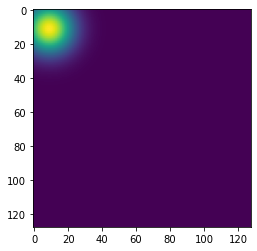

In [931]:
plt.imshow(gauss_kernel)

In [932]:
img_bboxes = img_target['bboxes']

In [933]:
def bbox2point_size_offset(img_target, downsample = 4):
    img_bboxes = img_target['bboxes']
    xmin, ymin = img_bboxes[:, 0], img_bboxes[:, 1]
    xmax, ymax = img_bboxes[:, 2], img_bboxes[:, 3]
    gt_img_cpoints = torch.stack([(xmin+xmax)/2, (ymin+ymax)/2],-1)
    gt_hm_cpoitns = torch.floor(gt_img_cpoints/downsample)
    gt_size = torch.stack([xmax-xmin, ymax-ymin],-1)
    gt_offsets =  gt_img_cpoints/downsample - gt_hm_cpoitns
    return gt_hm_cpoitns, gt_size, gt_offsets

In [934]:
gt_size

tensor([147., 139.])

In [935]:
gt_hm_cpoitns, gt_sizes, gt_offsets = bbox2point_size_offset(img_target)

In [936]:
gt_hm_cpoitns

tensor([[25., 51.],
        [16., 23.],
        [38., 45.],
        [60., 44.],
        [58., 81.]])

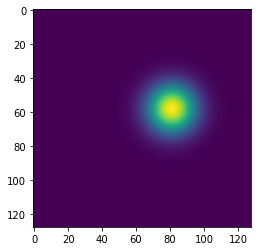

In [937]:
plt.imshow(gauss2D(hm_index, gt_hm_cpoitns[4]))

In [938]:
gt_size

tensor([147., 139.])

In [939]:
gt_hm.shape

torch.Size([5, 3, 128, 128])

In [940]:
target

[{'classes': tensor([0., 1., 2., 0., 1.]),
  'bboxes': tensor([[ 50.,  70., 150., 345.],
          [ 10.,  45., 124., 145.],
          [ 78.,  54., 230., 310.],
          [ 87.,  49., 400., 310.],
          [125., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': tensor([[ 10.,  70., 250., 345.],
          [100.,  45., 124., 145.],
          [178.,  54., 230., 310.],
          [187.,  49., 400., 310.],
          [145., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': tensor([[ 10.,  70., 250., 345.],
          [100.,  45., 124., 145.],
          [178.,  54., 230., 310.],
          [187.,  49., 400., 310.],
          [145., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': tensor([[ 10.,  70., 250., 345.],
          [100.,  45., 124., 145.],
          [178.,  54., 230., 310.],
          [187.,  49., 400., 310.],
          [145., 214., 340., 440.]])},
 {'classes': tensor([1., 0., 2., 1., 1.]),
  'bboxes': t

In [941]:
centerNet.mode = 'train'
r,l = centerNet(x, target)

In [942]:
hm.shape

torch.Size([5, 3, 128, 128])

In [943]:
keep_train = torch.sum(l['gt_hm'].permute(0,2,3,1) == 1,-1) > 0

In [944]:
keep_train.shape

torch.Size([5, 128, 128])

In [945]:
keep_train.shape

torch.Size([5, 128, 128])

In [946]:
l['gt_hm'].shape

torch.Size([5, 3, 128, 128])

In [947]:
l['gt_sz'][keep_train].shape

torch.Size([25, 2])

In [948]:
l['gt_os'][keep_train].shape

torch.Size([25, 2])

In [949]:
F.smooth_l1_loss(r[0]['size'].permute(0,2,3,1)[keep_train], l['gt_sz'][keep_train])

tensor(186.8232, grad_fn=<SmoothL1LossBackward>)

In [950]:
F.smooth_l1_loss(r[0]['offset'].permute(0,2,3,1)[keep_train], l['gt_os'][keep_train])

tensor(0.1212, grad_fn=<SmoothL1LossBackward>)

In [951]:
gt_hm =l['gt_hm']
pred_hm = r[0]['heatmap']
alpha = 2
beta = 4
hm_loss = (1-gt_hm).pow(beta)*pred_hm.pow(alpha)*torch.log(1 - pred_hm) + \
            (gt_hm).pow(beta)*(1 - pred_hm).pow(alpha)*torch.log(pred_hm)

In [952]:
hm_loss.sum()

tensor(-78134.2578, grad_fn=<SumBackward0>)

In [953]:
class focal_loss(nn.Module):
    def __init__(self, alpha = 2, beta = 4, reduction = 'sum', N = 1):
        super(focal_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.reduction = 'sum'
        self.N = N
        
    def forward(self, pred_hm, gt_hm):
        focalLoss = (1-gt_hm).pow(self.beta)*pred_hm.pow(self.alpha)*torch.log(1 - pred_hm) + \
                    (gt_hm).pow(self.beta)*(1 - pred_hm).pow(self.alpha)*torch.log(pred_hm)
        if self.reduction == 'sum':
            return -torch.sum(focalLoss)
        else:
            return -torch.sum(focalLoss)/N

In [954]:
r[0]['heatmap'].shape

torch.Size([5, 3, 128, 128])